# Synthetic data generation and ground truth definition for the toy model problem

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
radii = {'A': 24.0, 'B': 14.0, 'C': 16.0}
pair_distances = {
            'AA': 48.22,
            'AB': 38.5,
            'BC': 34.0  # minimum allowed C-C distance
        }
component_counts = {'A': 8, 'B': 8, 'C': 16}

# Start from the ideal structure that we already have 
array_A  = np.array([
    [ 63.  ,   0.  ,   0.  ],
    [ 44.55,  44.55,   0.  ],
    [  0.  ,  63.  ,   0.  ],
    [-44.55,  44.55,   0.  ],
    [-63.  ,   0.  ,   0.  ],
    [-44.55, -44.55,   0.  ],
    [ -0.  , -63.  ,   0.  ],
    [ 44.55, -44.55,   0.  ]
    ])
array_B = np.array([
    [ 63.  ,   0.  , -38.5 ],
    [ 44.55,  44.55, -38.5 ],
    [  0.  ,  63.  , -38.5 ],
    [-44.55,  44.55, -38.5 ],
    [-63.  ,   0.  , -38.5 ],
    [-44.55, -44.55, -38.5 ],
    [ -0.  , -63.  , -38.5 ],
    [ 44.55, -44.55, -38.5 ]
    ]) 
array_C = np.array([
    [ 47.00,   0.00, -68.50],
    [ 79.00,   0.00, -68.50],
    [ 55.86,  55.86, -68.50],
    [ 33.23,  33.23, -68.50],
    [  0.00,  47.00, -68.50],
    [  0.00,  79.00, -68.50],
    [-55.86,  55.86, -68.50],
    [-33.23,  33.23, -68.50],
    [-47.00,   0.00, -68.50],
    [-79.00,   0.00, -68.50],
    [-55.86, -55.86, -68.50],
    [-33.23, -33.23, -68.50],
    [  0.00, -47.00, -68.50],
    [  0.00, -79.00, -68.50],
    [ 55.86, -55.86, -68.50],
    [ 33.23, -33.23, -68.50],
    ])

## Procedure for creating simulated experimental data with noise
1) Add standard Gaussian noise with known width to the coordinates
2) Measure the pair distances between particles
3) Repeat this for n times so we have an ensemble of measured distances

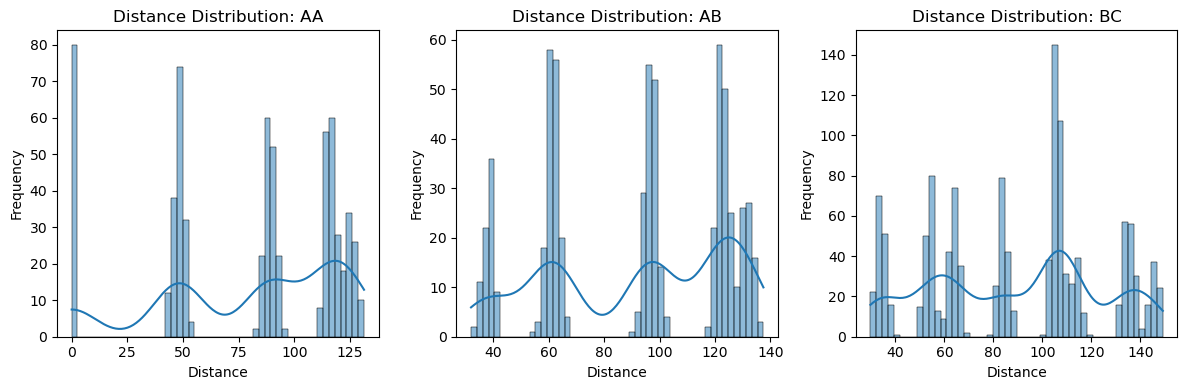

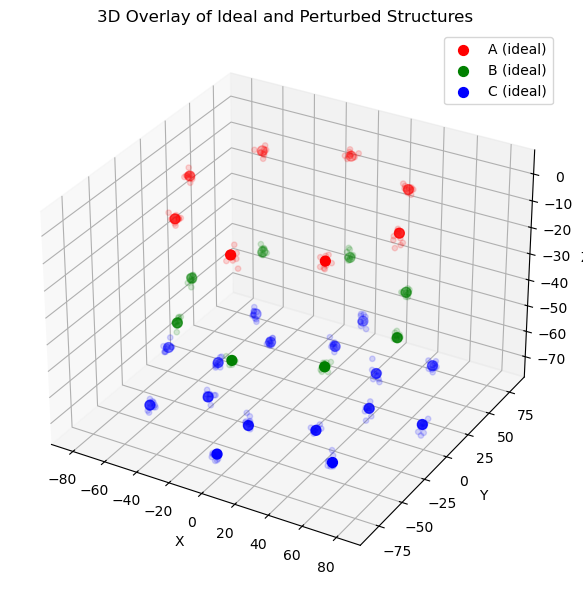

In [ ]:
class perturb_system():
    def __init__(self, array_A, array_B, array_C, radii, pair_distances, component_counts):
        self.array_A = array_A
        self.array_B = array_B
        self.array_C = array_C
        self.radii = radii
        self.pair_distances = pair_distances
        self.component_counts = component_counts
        self.mean = 0.0
        self.std_dev = {"A": 1.8, "B": 1.2, "C": 1.5}  # example std deviations for noise
        self.npert = 10  # number of perturbations / noisy datasets to generate
        
    def _add_gaussian_noise(self):
        noise_A = np.random.normal(self.mean, self.std_dev["A"], self.array_A.shape)
        noise_B = np.random.normal(self.mean, self.std_dev["B"], self.array_B.shape)
        noise_C = np.random.normal(self.mean, self.std_dev["C"], self.array_C.shape)
        self.array_A_noisy = self.array_A + noise_A
        self.array_B_noisy = self.array_B + noise_B
        self.array_C_noisy = self.array_C + noise_C

    def get_noisy_coordinates(self):
        self._add_gaussian_noise()
        return self.array_A_noisy, self.array_B_noisy, self.array_C_noisy
    
    def generate_noisy_datasets(self):
        perturbed_datasets = []
        for _ in range(self.npert):
            self._add_gaussian_noise()
            perturbed_datasets.append((
                self.array_A_noisy.copy(),
                self.array_B_noisy.copy(),
                self.array_C_noisy.copy()
            ))
        return perturbed_datasets
    
    def measure_pair_distances(self, array1, array2):
        from scipy.spatial import distance_matrix
        dist_matrix = distance_matrix(array1, array2)
        return dist_matrix
    
    def plot_distance_distributions(self, perturbed_datasets):
        """
        Plot distributions of the *lowest* pair distances (nearest neighbors)
        across all perturbed datasets and the ideal structure.
        """
        from scipy.spatial import distance_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt
        import numpy as np

        # Define how many nearest distances to keep for each pair type
        n_keep = {'AA': 8, 'AB': 8, 'BC': 16}

        def get_lowest_distances(array1, array2, n):
            dist_mat = distance_matrix(array1, array2)
            # Remove zeros (self-distances) for identical arrays (AA)
            if np.array_equal(array1, array2):
                dist_mat = dist_mat[~np.eye(dist_mat.shape[0], dtype=bool)].reshape(dist_mat.shape[0], -1)
            # Flatten and take the n smallest distances
            return np.sort(dist_mat.flatten())[:n]

        # Collect data
        all_distances = {'AA': [], 'AB': [], 'BC': []}

        # Include ideal structure first
        all_distances['AA'].extend(get_lowest_distances(self.array_A, self.array_A, n_keep['AA']))
        all_distances['AB'].extend(get_lowest_distances(self.array_A, self.array_B, n_keep['AB']))
        all_distances['BC'].extend(get_lowest_distances(self.array_B, self.array_C, n_keep['BC']))

        # Then all perturbed datasets
        for dataset in perturbed_datasets:
            array_A_noisy, array_B_noisy, array_C_noisy = dataset
            all_distances['AA'].extend(get_lowest_distances(array_A_noisy, array_A_noisy, n_keep['AA']))
            all_distances['AB'].extend(get_lowest_distances(array_A_noisy, array_B_noisy, n_keep['AB']))
            all_distances['BC'].extend(get_lowest_distances(array_B_noisy, array_C_noisy, n_keep['BC']))

        # --- Plot ---
        plt.figure(figsize=(12, 4))
        for i, key in enumerate(['AA', 'AB', 'BC']):
            plt.subplot(1, 3, i + 1)
            sns.histplot(all_distances[key], bins=20, kde=True)
            plt.title(f'Lowest {n_keep[key]} Distances: {key}')
            plt.xlabel('Distance')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
            
    def visualize_3d_structures(self, perturbed_datasets):
        """
        Visualize the ideal (original) and perturbed structures together in 3D.
        """
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the ideal/original structures
        ax.scatter(self.array_A[:,0], self.array_A[:,1], self.array_A[:,2], 
                c='r', marker='o', s=50, label='A (ideal)')
        ax.scatter(self.array_B[:,0], self.array_B[:,1], self.array_B[:,2], 
                c='g', marker='o', s=50, label='B (ideal)')
        ax.scatter(self.array_C[:,0], self.array_C[:,1], self.array_C[:,2], 
                c='b', marker='o', s=50, label='C (ideal)')

        # Overlay perturbed datasets
        for i, dataset in enumerate(perturbed_datasets):
            array_A_noisy, array_B_noisy, array_C_noisy = dataset
            ax.scatter(array_A_noisy[:,0], array_A_noisy[:,1], array_A_noisy[:,2], 
                    c='r', alpha=0.15, s=15)
            ax.scatter(array_B_noisy[:,0], array_B_noisy[:,1], array_B_noisy[:,2], 
                    c='g', alpha=0.15, s=15)
            ax.scatter(array_C_noisy[:,0], array_C_noisy[:,1], array_C_noisy[:,2], 
                    c='b', alpha=0.15, s=15)

        ax.set_title('3D Overlay of Ideal and Perturbed Structures')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.tight_layout()
        plt.show()
    
perturber = perturb_system(array_A, array_B, array_C, radii, pair_distances, component_counts)
noisy_datasets = perturber.generate_noisy_datasets()
perturber.plot_distance_distributions(noisy_datasets)
perturber.visualize_3d_structures(noisy_datasets)